# Simulation of smeared FoM 

1. For the first decay step, a random τ1was picked according to the τlikelihood function h(τ ) (see Fig. 4). Fourteen random lifetimes from the exponential distribution g(t)defined by this τ1were generated. 
2. For the second decay step, a random τ2was picked according to the τlikelihood function  h(τ ). Fourteen random lifetimes from the exponential distribution g(t)defined by this τ 2 were generated. 
3. For the third decay step, a random τ3was picked according to the τlikelihood function  h(τ ). Ten random lifetimes from the exponential distribution g(t)defined by this τ3were  generated. 
4. The generated lifetimes were collected in fourteen chains – ten with three lifetimes, and four  with two lifetimes.

In [232]:
import numpy as np
import os, sys, yaml, re
from IPython.display import display, Markdown, Latex #Can write latex too!!!!
import matplotlib.pyplot as plt

In [233]:
class DecayChain(yaml.YAMLObject):
    
    yaml_tag = u'!DecayChain'
    
    def __init__(self, idd="", be="", pi="", ie="", it="", ea=[], eas=[], ta=[]):
        self.ID = idd
        self.BeamEnergy = be
        self.Pixel = pi
        self.ImplantEnergy = ie
        self.ImplantTime = it
        self.EAlpha, self.EAlphaSigma, self.TAlpha = ea, eas, ta

class SetDecayChains:
    
    def __init__(self, path='', ids=[]):
        s_files = " ".join(os.listdir(path))
        files = []
        for s in ids:
            files += (sorted(re.findall(string=s_files, pattern="Chain"+s+"\d+.yml")))
        print("Reading the following files:", files)
        self.Chains = []
        for f in files:
            f_in = open(path+f, 'r')
            self.Chains.append(yaml.load(f_in))
            f_in.close()

In [234]:
s_path = "E115_Chains/"
s_id = ["14", "11", "17"]

setDC = SetDecayChains(s_path, s_id)
max_steps = 0
for chain in setDC.Chains:
    if len(chain.TAlpha) > max_steps:
        max_steps = len(chain.TAlpha)
print("Max steps=", max_steps)
times = np.zeros((len(setDC.Chains), max_steps))
for row, chain in enumerate(setDC.Chains):
    steps = len(chain.TAlpha)
    for i in range(max_steps):
        if i < steps:
            times[row][i] = chain.TAlpha[i]
        else:
            times[row][i] = np.nan       
times

Reading the following files: ['Chain1401.yml', 'Chain1402.yml', 'Chain1403.yml', 'Chain1404.yml', 'Chain1405.yml', 'Chain1406.yml', 'Chain1407.yml', 'Chain1101.yml', 'Chain1102.yml', 'Chain1103.yml', 'Chain1104.yml', 'Chain1701.yml', 'Chain1702.yml', 'Chain1703.yml']
Max steps= 3


array([[  2.27000000e-01,   3.78000000e-01,              nan],
       [  6.45000000e-02,   3.66000000e-01,              nan],
       [  2.61000000e-01,   1.15000000e+00,   3.43000000e-01],
       [  1.46000000e+00,   2.62000000e-02,   4.32000000e-01],
       [  3.45000000e-01,   3.69000000e-01,   1.44000000e+01],
       [  2.10000000e-01,   1.05000000e+00,   8.27000000e+00],
       [  8.15000000e-01,   2.33000000e+00,   2.89000000e+00],
       [  2.56200000e-01,   1.40270000e+00,   1.97750000e+00],
       [  6.61000000e-02,   1.55000000e+00,   2.36380000e+00],
       [  2.35070000e+00,   2.25822000e+01,   6.01855000e+01],
       [  5.36000000e-02,   4.67100000e-01,   9.08000000e-02],
       [  2.14000000e-01,   1.54000000e+00,   7.57000000e+00],
       [  5.91000000e-02,   8.24000000e-01,              nan],
       [  4.55000000e-02,   1.42000000e-02,              nan]])

In [235]:
N_j = np.count_nonzero(~np.isnan(times), axis=0)
N_j

array([14, 14, 10])

In [236]:
t_mean_j = np.nanmean(times, axis=0)
t_mean_j

array([ 0.45912143,  2.4321    ,  9.85226   ])

## Likelihood function for $\tau$

In [237]:
from scipy.special import factorial
class tau_likelihood_func(object):
    def __init__(self, t_mean, N_j):
        self.t_mean = t_mean
        self.N_j = N_j
        self.factor1 = np.divide(np.multiply(np.power(self.N_j, self.N_j-1), np.power(self.t_mean, self.N_j-1)), factorial(N_j-2))
        self.factor2 = -np.multiply(self.N_j, self.t_mean)
        #print("factor1=", self.factor1, np.shape(self.factor1))
                                 
    def __call__(self, tau):
        #ret = np.empty((len(tau), len(self.N_j)))
        print(tau, np.shape(tau))
        ret = np.multiply(np.divide(self.factor1, np.power(tau, self.N_j)), np.exp(np.divide(self.factor2, tau)))
        return ret

tau_likelihood = tau_likelihood_func(t_mean_j, N_j)

### Generating $\tau$ values to be used in the random sampling procedure

[[  1.00000000e-05   1.00000000e-05   1.00000000e-05]
 [  1.93665938e-04   9.82936294e-04   3.95129713e-03]
 [  3.77331876e-04   1.95587259e-03   7.89259426e-03]
 ..., 
 [  1.83611838e+00   9.72645413e+00   3.94011574e+01]
 [  1.83630205e+00   9.72742706e+00   3.94050987e+01]
 [  1.83648571e+00   9.72840000e+00   3.94090400e+01]] (10000, 3)


<IPython.core.display.Javascript object>


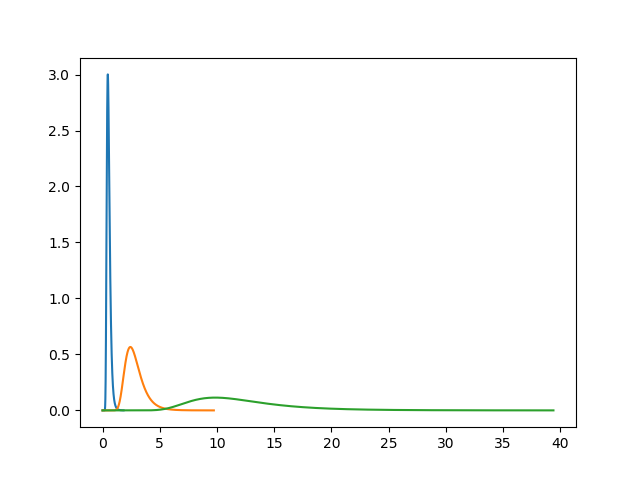

In [238]:
%matplotlib notebook
nbr_sets = 10000
tau = np.empty((nbr_sets, len(N_j)))
for i in range(len(N_j)):
    tau[:,i] = np.linspace(0.00001, t_mean_j[i]*4, nbr_sets)
tau_l = tau_likelihood(tau)
plt.figure()
plt.plot(tau, tau_l)
plt.show()

<IPython.core.display.Javascript object>


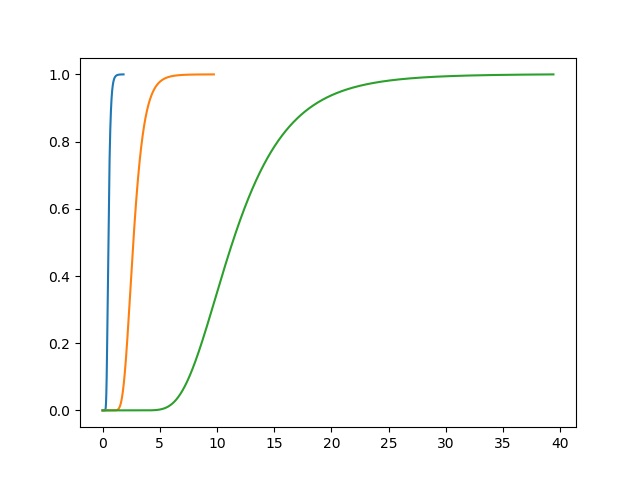

In [131]:
cdf = np.cumsum(tau_l, axis=0)
cdf = np.divide(cdf, cdf[-1,:])
cdf, np.shape(cdf)
plt.figure()
plt.plot(tau,cdf)
plt.show()

## Random sampling from the created CDF and plotting

In [213]:
cdf = np.cumsum(tau_l, axis=0)
cdf = np.divide(cdf, cdf[-1,:])
rands = np.random.rand(nbr_sets, len(N_j))

rand_taus = np.empty(np.shape(rands))
for i in range(len(N_j)):
    inds = np.searchsorted(cdf[:,i], rands[:,i])
    rand_taus[:,i] = tau[inds,i]
np.shape(rand_taus), np.shape(tau_l), np.shape(tau)

((10000, 3), (10000, 3), (10000, 3))

In [132]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'];

<IPython.core.display.Javascript object>


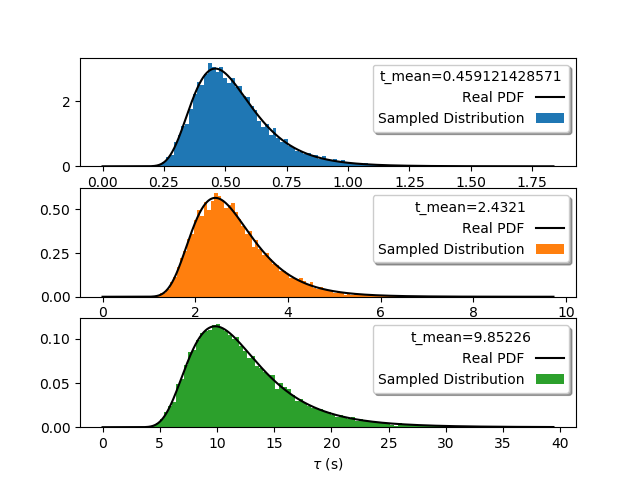

Text(0.5,0,'$\\tau$ (s)')

In [214]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1)# sharex=True, sharey=True)
t_mean_j = np.nanmean(times, axis=0)
an = "\bar{t}="+str(t_mean_j)
for i,ax in enumerate(f.axes):
    ax.plot(tau[:,i],tau_l[:,i], color='black', label="Real PDF")
    ax.hist(rand_taus[:,i], bins=100, color=colors[i], normed=True, label="Sampled Distribution")
    #ax.annotate(an[i],xy=(0.75,.8), fontsize=24, xycoords='axes fraction', color='k')
    ax.legend(loc='upper right',markerfirst=False, title="t_mean="+str(t_mean_j[i]), frameon=True,shadow=True,fancybox=True)
plt.xlabel(r"$\tau$ (s)")

<IPython.core.display.Javascript object>


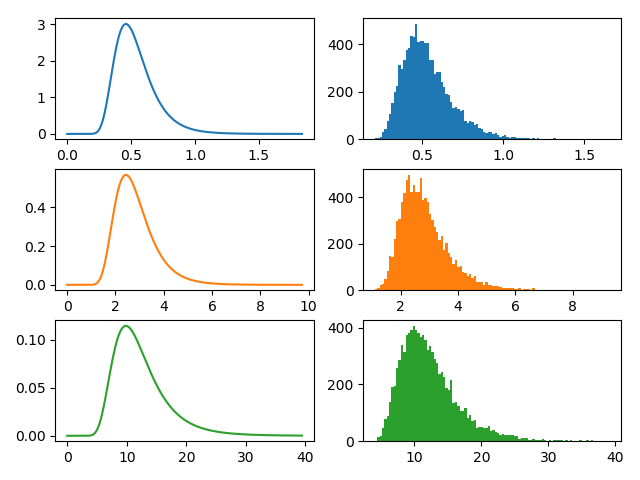

In [134]:
plt.figure()
for i in range(len(N_j)):
    ax = plt.subplot2grid((len(N_j),2), (i, 0), rowspan=1, colspan=1)
    ax.plot(tau[:,i],tau_l[:,i], color=colors[i])
    ax = plt.subplot2grid((len(N_j),2), (i, 1), rowspan=1, colspan=1)
    plt.hist(rand_taus[:,i], bins=100, color=colors[i])
plt.tight_layout(w_pad=.2,h_pad=.2);

# Random sampling for each decay step on the basis of the sampled $\tau$

In [215]:
shape = (nbr_sets, *np.shape(times))
sim = np.empty(shape)
sim = np.random.exponential(scale=1, size=shape)
for i in range(nbr_sets):
    for j in range(len(N_j)):
        sim[i, :, j] = np.random.exponential(scale=rand_taus[i, j], size=shape[1])
    sim[i][np.isnan(times)] = np.nan
sim[0:2]

array([[[  9.74121955e-02,   8.14451360e-01,              nan],
        [  1.90142013e+00,   5.20529386e+00,              nan],
        [  2.90568502e-01,   6.68519642e+00,   8.16572620e+00],
        [  6.32383329e-01,   4.90246187e-01,   7.24208464e+00],
        [  4.28968180e-01,   9.91776458e+00,   1.23285999e+01],
        [  4.46356406e-01,   1.08773934e+00,   1.76844606e+01],
        [  8.53340666e-01,   7.62606930e-01,   6.27644754e+00],
        [  3.37320912e-01,   1.83774959e+00,   6.83076380e+00],
        [  1.03376489e+00,   7.11079152e+00,   1.43955511e+01],
        [  4.25853159e-01,   1.64359142e+00,   3.82590493e+01],
        [  5.44581031e-01,   4.92216554e-01,   2.45925136e+01],
        [  2.53607709e-01,   1.85052750e+00,   7.87530657e+00],
        [  7.09212660e-01,   9.95111508e+00,              nan],
        [  3.24118831e-01,   3.33414997e+00,              nan]],

       [[  3.79165954e-01,   3.65746357e+00,              nan],
        [  2.57092067e-01,   1.7902374

In [216]:
def fom_smeared(N_j, t_bar, times):
    ret = np.zeros((len(times[:]), len(N_j)))
    for i, t in enumerate(times[:]):
        temp = np.empty(len(t))
        prod = np.empty(len(t))
        np.multiply(N_j, t_bar, out=prod)
        np.power(prod, np.subtract(N_j,1), out=temp) #numerator
        np.divide(temp, np.power(np.add(prod, t), N_j), out=temp) #division with denominator
        np.multiply(temp, np.multiply(t, np.subtract(N_j, 1)), out=temp)
        ret[i] = temp
    return ret

def g_nan_mean(data):
    ret = np.empty(np.shape(data)[0])
    for i in range(len(data[:, 0])):
        temp = 1
        steps = 0
        for j in range(np.shape(data)[1]):
            if not np.isnan(data[i,j]):
                temp *= data[i,j]
            else:
                break
            steps += 1
        ret[i] = temp**(1./steps)
    return ret

In [217]:
t_bar = np.nanmean(sim[0], axis=0)
t_bar

array([  0.59135061,   3.65596002,  14.36505033])

In [218]:
fom = fom_smeared(N_j, t_bar, sim[0])
fom

array([[ 0.12985558,  0.1658408 ,         nan],
       [ 0.1651986 ,  0.34070533,         nan],
       [ 0.28150202,  0.30446345,  0.29431994],
       [ 0.35432722,  0.10896035,  0.27745426],
       [ 0.33208306,  0.21102964,  0.3390443 ],
       [ 0.33602725,  0.205816  ,  0.34698742],
       [ 0.33933397,  0.15746795,  0.25640335],
       [ 0.30282738,  0.28485265,  0.26893774],
       [ 0.31258922,  0.29227138,  0.34705523],
       [ 0.33132707,  0.26818436,  0.22604036],
       [ 0.35050215,  0.10933989,  0.31727753],
       [ 0.26102143,  0.28586722,  0.28933982],
       [ 0.35237497,  0.21012786,         nan],
       [ 0.29728942,  0.35002456,         nan]])

In [219]:
fom_geom = g_nan_mean(fom)
fom_final = np.mean(fom_geom)
fom_final

0.263539434221

In [220]:
fom = np.empty(shape)
fom_geom = np.empty(shape[0:2])
fom_final = np.empty(nbr_sets)
for i in range(nbr_sets):
    t_bar = np.nanmean(sim[i], axis=0)
    fom[i] = fom_smeared(N_j, t_bar, sim[i])
    fom_geom[i] = g_nan_mean(fom[i])
    fom_final[i] = np.mean(fom_geom[i])

## Plot the simulations

In [221]:
q2p5, q97p5 = np.percentile(fom_final, 2.5), np.percentile(fom_final, 97.5)
q5, q95 = np.percentile(fom_final, 5), np.percentile(fom_final, 95)
q1, q99 = np.percentile(fom_final, 1), np.percentile(fom_final, 99)
fom_final_mean = np.mean(fom_final)
print("FoM final = ", fom_final_mean)
print("95% =", "["+str(q2p5)+", "+str(q97p5)+"]")
print("90% =", "["+str(q5)+", "+str(q95)+"]")
print("98% =", "["+str(q1)+", "+str(q99)+"]")

FoM final =  0.229149691501
95% = [0.186444320743, 0.269631723184]
90% = [0.193998075809, 0.263721889402]
98% = [0.178199884661, 0.275556692217]


<IPython.core.display.Javascript object>


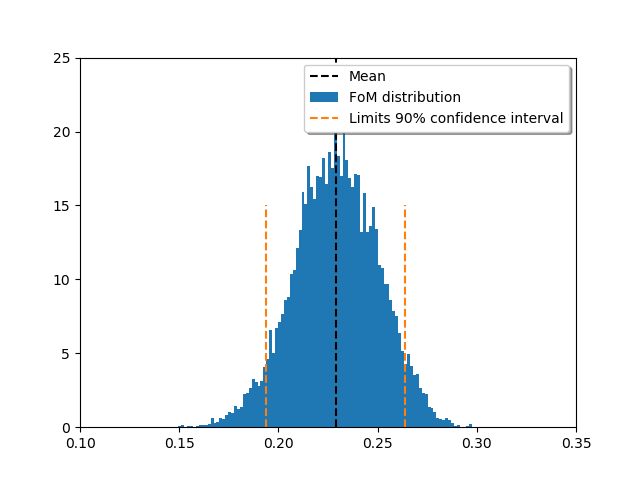

In [231]:
plt.figure()
ax = plt.gca()
plt.hist(fom_final, bins=100, normed=True, label="FoM distribution")
ax.axvline(fom_final_mean, linestyle="--", color='k', label="Mean")
ax.vlines([q5, fom_final_mean, q95], ymin=0, ymax=15, linestyle="--", color=colors[1], label="Limits 90% confidence interval")
plt.ylim((0, 25))
plt.xlim((0.10, 0.35))
plt.legend(loc='best',markerfirst=True, frameon=True,shadow=True,fancybox=True)
plt.show()

In [52]:
import sympy as sym
#sym.init_printing(use_latex='mathjax')
from IPython.display import Markdown
tau, N, t_bar, c1, c2 = sym.symbols(r'\tau N \bar{t}, c_1, c_2')
expr = (N**(N-1) /sym.factorial(N-2)) * (t_bar**(N-1) / tau**N) * sym.exp(-N*t_bar/tau)
expr = (c1 / tau**5) * sym.exp(-N*t_bar/tau)
Markdown('$'+sym.latex(sym.Integral(expr, tau) )+' = '+sym.latex(sym.integrate(expr, tau))+'$')

$\int \frac{c_{1}}{\tau^{5}} e^{- \frac{N \bar{t}}{\tau}}\, d\tau = \frac{e^{- \frac{N \bar{t}}{\tau}}}{N^{10} \bar{t}^{10} \tau^{3}} \left(N^{9} \bar{t}^{9} c_{1} + 3 N^{8} \bar{t}^{8} \tau c_{1} + 6 N^{7} \bar{t}^{7} \tau^{2} c_{1} + 6 N^{6} \bar{t}^{6} \tau^{3} c_{1}\right)$

In [51]:
sym.integrate(expr, tau)

                    ⎛   2  -N                -N           ⎛       N⋅\bar{t}⎞  
                    ⎜  N ⋅N  ⋅\bar{t}⋅\bar{t}  ⋅Γ(N - 1)⋅γ⎜N - 1, ─────────⎟  
 N - 1        N - 1 ⎜                                     ⎝          \tau  ⎠  
N     ⋅\bar{t}     ⋅⎜- ───────────────────────────────────────────────────── +
                    ⎝                           Γ(N)                          
──────────────────────────────────────────────────────────────────────────────
                                                              (N - 2)!        

    -N                -N           ⎛       N⋅\bar{t}⎞⎞
 N⋅N  ⋅\bar{t}⋅\bar{t}  ⋅Γ(N - 1)⋅γ⎜N - 1, ─────────⎟⎟
                                   ⎝          \tau  ⎠⎟
 ────────────────────────────────────────────────────⎟
                         Γ(N)                        ⎠
──────────────────────────────────────────────────────
                                                      

$\int \tau^{- N} c_{1} e^{- \frac{N \bar{t}}{\tau}}\, d\tau = c_{1} \left(- \frac{N^{2} N^{- N} \bar{t}}{\Gamma{\left(N \right)}} \bar{t}^{- N} \Gamma{\left(N - 1 \right)} \gamma\left(N - 1, \frac{N \bar{t}}{\tau}\right) + \frac{N N^{- N} \bar{t}}{\Gamma{\left(N \right)}} \bar{t}^{- N} \Gamma{\left(N - 1 \right)} \gamma\left(N - 1, \frac{N \bar{t}}{\tau}\right)\right)$

In [36]:
tau = sym.symbols('tau')
expr = (1 / tau**3) * sym.exp(-3/tau)
print(sym.latex( sym.Integral(expr, tau) ), '=', sym.latex( sym.integrate(expr, tau) ))

\int \frac{e^{- \frac{3}{\tau}}}{\tau^{3}}\, d\tau = \frac{e^{- \frac{3}{\tau}}}{9 \tau} \left(\tau + 3\right)


In [25]:
sym.Integral(sym.sqrt(1/tau))

⌠                   
⎮     ______        
⎮    ╱  1           
⎮   ╱  ────  d(\tau)
⎮ ╲╱   \tau         
⌡                   

In [9]:
from scipy.special import factorial
factorial(np.array([2, 3]))

array([ 2.,  6.])

In [10]:
tau = tau[:, np.newaxis]
temp = np.repeat(tau, repeats=3, axis=1)
temp, np.shape(temp)

TypeError: 'Symbol' object is not subscriptable

In [ ]:
np.tile(tau, 3)

For each step j, the likelihood function for the true lifetime τj, given by Njand  ̄tj, is  determined. 

For each step j, a τjis selected with a probability governed by the likelihood function for  τj, and then a set of Njlifetimes are generated from the exponential distribution defined by  this τj. This procedure is repeated until a smooth histogram emerges.